In [1]:
import numpy as np
from scipy.ndimage import convolve
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from IPython.display import HTML
from matplotlib.colors import ListedColormap
import scipy.stats as stats

In [2]:
# Rulebook for preferential attachment and cluster assignment
def rulebook(life, cluster_ids, new_cluster_prob):
    # Kernel to sum 8 neighbors
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]])
    kernel = np.flipud(kernel)


    new_life = life.copy()
    new_cluster_ids = cluster_ids.copy()
    
    # Calculate the number of active neighbors for each cell
    neighbors = convolve(life, kernel, mode='constant', cval=0)
    
    # Calculate activation probabilities based on number of active neighbors
    activation_probabilities = neighbors / 8.0
    new_active_cells = (np.random.random(life.shape) < activation_probabilities) & (life == 0)
    
    for x, y in zip(*np.where(new_active_cells)):
        # Get cluster IDs of neighboring cells
        neighbor_ids = cluster_ids[max(x-1, 0):min(x+2, 200), max(y-1, 0):min(y+2, 200)].ravel()
        neighbor_ids = neighbor_ids[neighbor_ids > 0]
        
        # Decide whether to create a new cluster or join an existing one
        if np.random.random() < new_cluster_prob:
            new_cluster_id = cluster_ids.max()
            new_cluster_ids[x, y] = new_cluster_id + 1
        elif neighbor_ids.size > 0:
            # Assign the majority neighbor's cluster ID to the cell
            new_cluster_ids[x, y] = np.bincount(neighbor_ids).argmax()
    
    # Update the life array based on newly activated cells
    new_life = new_life | new_active_cells.astype(np.uint8)
    return new_life, new_cluster_ids

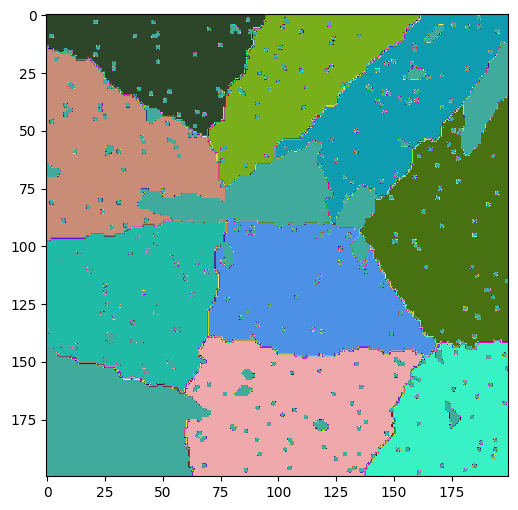

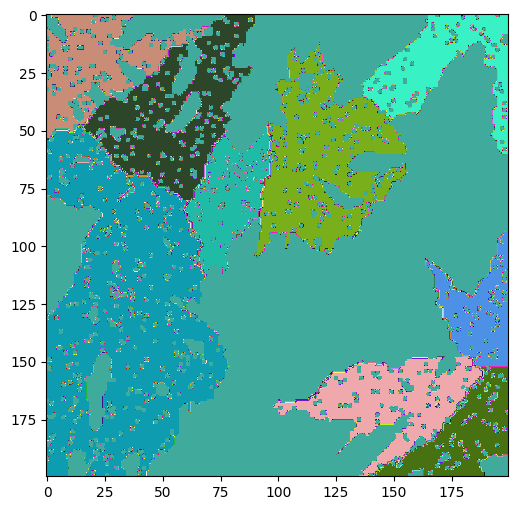

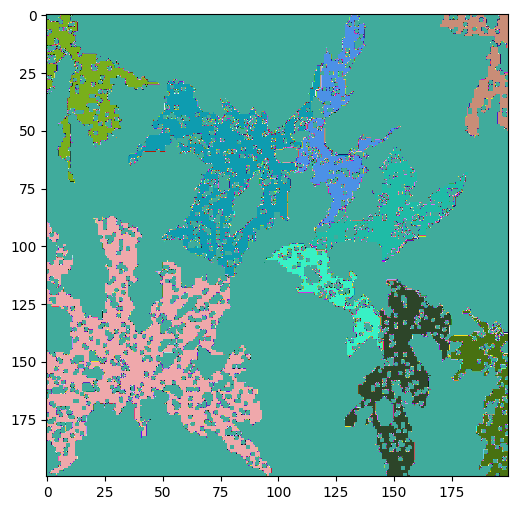

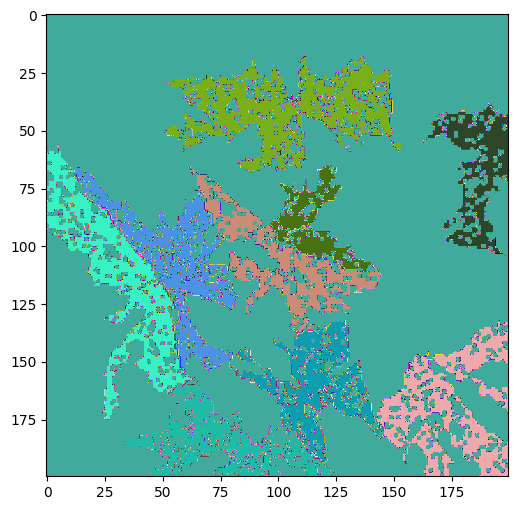

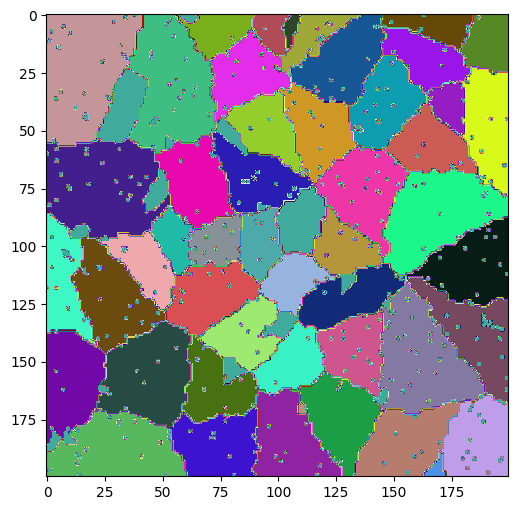

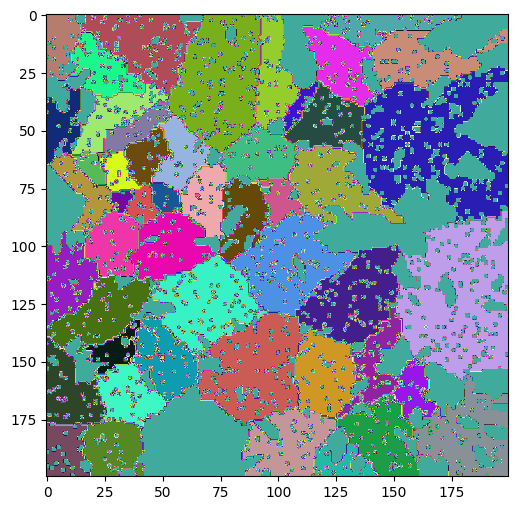

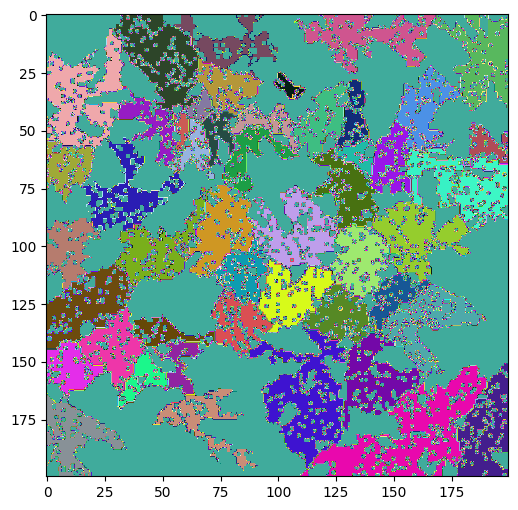

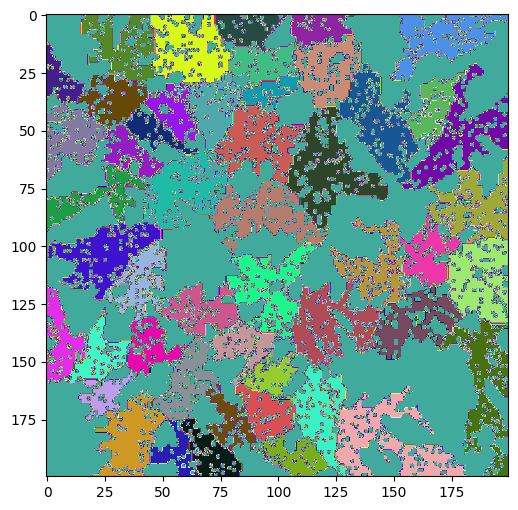

In [8]:
plt.rcParams["animation.html"] = "jshtml"

# Create a colormap with random colors for each cluster
colors = np.random.rand(200, 3)
colormap = ListedColormap(np.vstack([[0, 0, 0], colors]))

initial_cells_vals = [10, 50, 100, 250]
p_vals = [0.01, 0.05, 0.1, 0.2]

for i_cells in initial_cells_vals:
    for p_val in p_vals:
        # Initialize grid with multiple active cells
        grid = np.zeros((200, 200), dtype=np.uint8)
        cluster_ids = np.zeros((200, 200), dtype=np.int32)
        num_initial_cells = i_cells
        initial_positions = np.random.choice(200, (num_initial_cells, 2))
        for idx, (x, y) in enumerate(initial_positions):
            grid[x, y] = 1
            cluster_ids[x, y] = idx + 1

        # Initialize figure
        fig, ax = plt.subplots(figsize=(6, 6))
        im = ax.imshow(cluster_ids, cmap=colormap)

        # Animation function
        def animate(i):
            global grid, cluster_ids
            # Update the grid based on the rulebook
            grid, cluster_ids = rulebook(grid, cluster_ids, p_val)
            im.set_array(cluster_ids)
            return [im]

        # Animation details
        fps = 30
        anim = FuncAnimation(fig, animate, frames=10*fps, interval=1000/fps)
        anim.save(f'gifs/preferential_attachment_clusters_colored_rulebook_{i_cells}_{p_val}.gif', dpi=90)

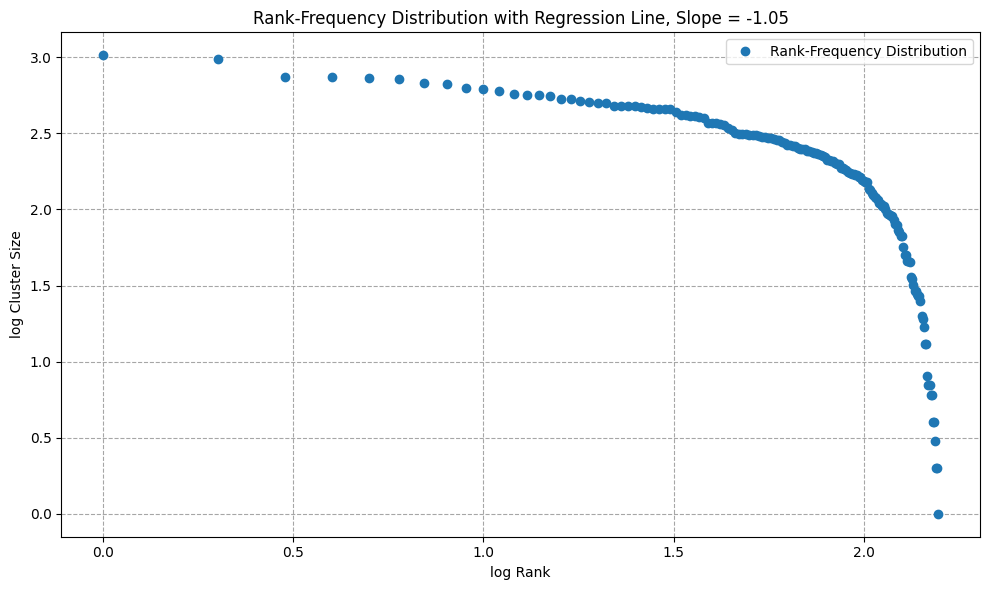

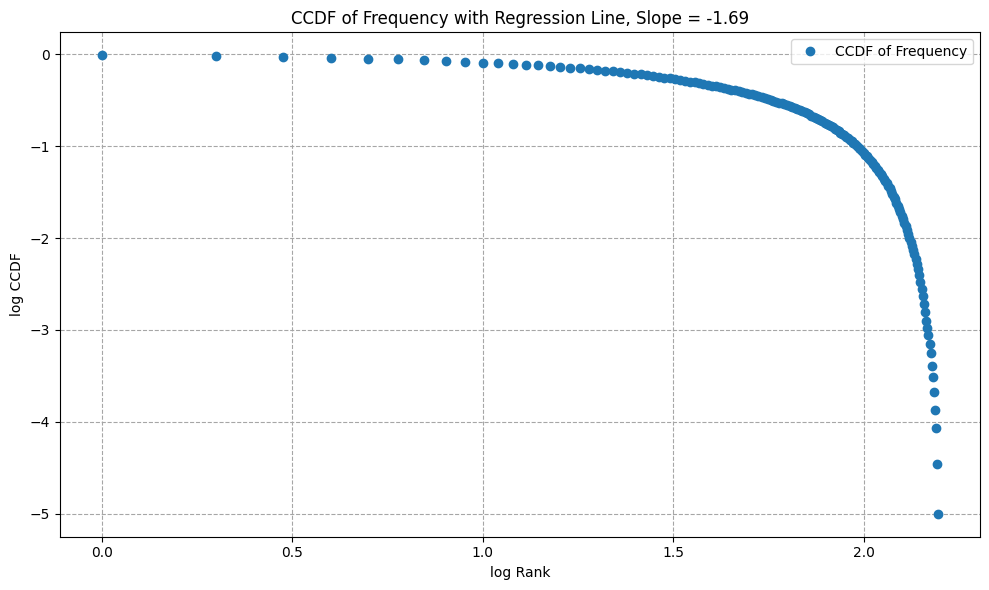

In [15]:
# analysis of Group Size Distribution
unique, counts = np.unique(cluster_ids[cluster_ids > 0], return_counts=True)
sorted_counts = sorted(counts)[::-1]
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(np.arange(1, len(sorted_counts) + 1)), np.log10(sorted_counts))

# Plotting the rank-frequency distribution
plt.figure(figsize=(10, 6))
plt.plot(np.log10(np.arange(1, len(sorted_counts) + 1)), np.log10(sorted_counts), 'o', label='Rank-Frequency Distribution')
plt.xlabel('log Rank')
plt.ylabel('log Cluster Size')
plt.title(f'Rank-Frequency Distribution with Regression Line, Slope = {slope:.2f}')
plt.legend()
plt.grid(True, which="both", ls="--", c='0.65')
plt.tight_layout()

# Save the plot to a file
plt.savefig('rank_frequency_distribution.png')
plt.show()

ccdf = 1 - np.cumsum(sorted_counts)/sum(sorted_counts)
ccdf += 1e-5
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(np.arange(1, len(sorted_counts) + 1)), np.log10(ccdf))
# Plotting the CCDF of Frequency
plt.figure(figsize=(10, 6))
plt.plot(np.log10(np.arange(1, len(sorted_counts) + 1)), np.log10(ccdf), 'o', label='CCDF of Frequency')
plt.xlabel('log Rank')
plt.ylabel('log CCDF')
plt.title(f'CCDF of Frequency with Regression Line, Slope = {slope:.2f}')
plt.legend()
plt.grid(True, which="both", ls="--", c='0.65')
plt.tight_layout()

# Save the plot to a file
plt.savefig('ccdf_frequency.png')
plt.show()
